## Importing

In [112]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
        sys.path.append(module_path)

In [113]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from system_simulation.common.simulation_engine import SimulationEngine
from system_simulation.event_handlers.multichannel_fixed_queue_with_reneging_event_handler \
            import MultichannelFixedQueueWithRenegingEventHandler
from system_simulation.event_handlers.multichannel_with_warming_up_event_handler \
            import MultichannelWithWarmingUpEventHandler

from common import count_state_probabilities, compute_theoretical_probabilities

In [114]:
sns.set_style('darkgrid') 
plt.rc('axes', titlesize=18)    
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=13)   
plt.rc('ytick', labelsize=13)    
plt.rc('legend', fontsize=13)    
plt.rc('font', size=13)         

In [115]:
def plot_histograms(empirical_probabilities: np.array, theoretical_probabilities: np.array):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.set_title('Sumulation probabilities')
    ax1.vlines(range(empirical_probabilities.size), 0, empirical_probabilities)
    
    ax2.set_title('Theoretical probabilities')
    ax2.vlines(range(empirical_probabilities.size), 0, empirical_probabilities)
    

def compute_refuse_probability(probabilities):
    return probabilities[-1]

def compute_relative_throughput(probabilities):
    return 1 - compute_refuse_probability(probabilities)

def compute_absolute_throughput(probabilities, arrival_rate):
    return arrival_rate * compute_relative_throughput(probabilities)

def compute_mean_customers_in_system_count(probabilities, channels_count):
    before_queue_sum = np.sum(np.arange(channels_count + 1) * probabilities[:channels_count + 1])
    after_queue_sum = np.sum(channels_count * probabilities[channels_count + 1:]) 
    return  before_queue_sum + after_queue_sum

def compute_mean_customers_in_queue_count(probabilities, channels_count):
    return np.sum(np.arange(1, probabilities.size - channels_count) * probabilities[channels_count + 1:])

def compute_mean_customer_time_in_system(probabilities, arrival_rate, service_rate, reneging_rate):
    return compute_absolute_throughput(probabilities, arrival_rate) / service_rate + 1.0 / reneging_rate

def compute_mean_busy_channels_count(probabilities, channels_count):
    return np.sum(np.arange(channels_count + 1) * probabilities[:channels_count + 1])

## Multichannel fixed queue with reneging system analysis

In [116]:
simulation_start_time = 0
simulation_finish_time = 100000

channels_count = 10
queue_capacity = 2

arrival_rate = 2
service_rate = 0.1
reneging_rate = 0.1

system_events_df_filename = 'multichannel_fixed_queue_with_reneging_system_simulation.csv'

In [117]:
simulation_engine = SimulationEngine(simulation_start_time, simulation_finish_time)
event_handler = MultichannelFixedQueueWithRenegingEventHandler(channels_count, 
                                                               queue_capacity, 
                                                               arrival_rate, service_rate, reneging_rate, 
                                                               system_events_df_filename)
simulation_engine.register_event_handler(event_handler)
simulation_engine.start()

In [118]:
system_events_df = pd.read_csv(system_events_df_filename, index_col=0)
system_events_df = system_events_df[system_events_df['arrival_event_time'] > 10000]
departure_times = system_events_df['reneging_event_time'].fillna(value=system_events_df['service_event_time']).dropna()
arrival_times = system_events_df['arrival_event_time'][departure_times.index].values.reshape((-1, 1))
departure_times = departure_times.values.reshape((-1, 1))

customers_arrival_and_departure = np.hstack((arrival_times, departure_times))
states_count = channels_count + queue_capacity + 1
system_state_probabilities = count_state_probabilities(customers_arrival_and_departure, states_count,
                                                       10000, simulation_finish_time)

In [119]:
arrival_rates = np.array([arrival_rate] * (states_count - 1))
departure_rates = np.hstack((service_rate * np.arange(1, channels_count + 1),
                             service_rate * channels_count + reneging_rate * np.arange(1, queue_capacity + 1)))
theoretical_state_probabilities = compute_theoretical_probabilities(arrival_rates, departure_rates)

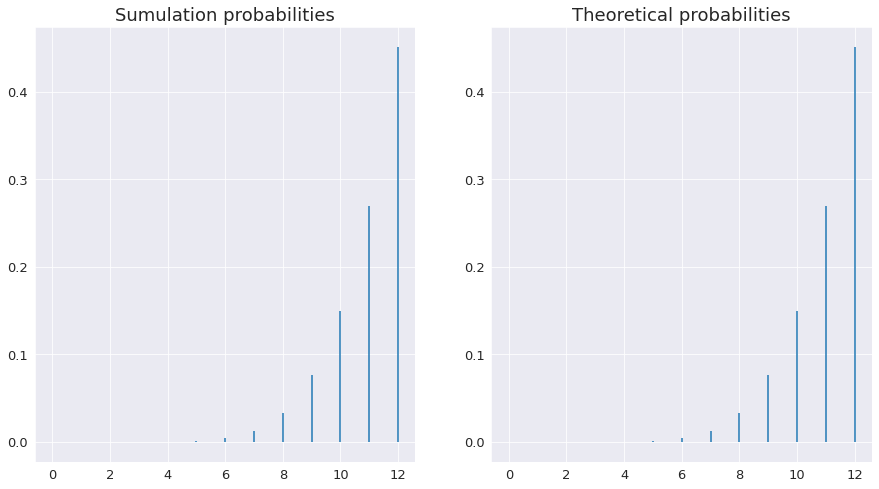

In [120]:
plot_histograms(system_state_probabilities, theoretical_state_probabilities)

### Absolute throughput

In [121]:
theoretical_absolute_throughput = compute_absolute_throughput(theoretical_state_probabilities, arrival_rate)
empirical_absolute_throughput = compute_absolute_throughput(system_state_probabilities, arrival_rate)
theoretical_absolute_throughput, empirical_absolute_throughput

(1.0964229213706083, 1.0972779487874136)

### Refuse probability 

In [122]:
theoretical_refuse_probability = compute_refuse_probability(theoretical_state_probabilities)
empirical_refuse_probability = compute_refuse_probability(system_state_probabilities)
theoretical_refuse_probability, empirical_refuse_probability

(0.4517885393146958, 0.4513610256062932)

### Mean customers count in system

In [123]:
theoretical_mean_customers_in_system_count = compute_mean_customers_in_system_count(theoretical_state_probabilities, channels_count)
empirical_mean_customers_in_system_count = compute_mean_customers_in_system_count(system_state_probabilities, channels_count)
theoretical_mean_customers_in_system_count, empirical_mean_customers_in_system_count

(9.789579011487877, 9.78992110521695)

### Mean customers count in queue

In [124]:
theoretical_mean_customers_in_queue_count = compute_mean_customers_in_queue_count(theoretical_state_probabilities, channels_count)
empirical_mean_customers_in_system_count = compute_mean_customers_in_queue_count(system_state_probabilities, channels_count)
theoretical_mean_customers_in_queue_count, empirical_mean_customers_in_system_count

(1.174650202218209, 1.1721617781501046)

### Mean customer time in system

In [125]:
theoretical_mean_customer_time_in_system = compute_mean_customer_time_in_system(theoretical_state_probabilities, arrival_rate, service_rate, reneging_rate)
empirical_mean_customer_time_in_system = compute_mean_customer_time_in_system(system_state_probabilities, arrival_rate, service_rate, reneging_rate)
theoretical_mean_customer_time_in_system, empirical_mean_customer_time_in_system

(20.964229213706083, 20.972779487874135)

### Mean busy channels count

In [126]:
theoretical_mean_channels_count = compute_mean_busy_channels_count(theoretical_state_probabilities, channels_count)
empirical_mean_channels_count = compute_mean_busy_channels_count(system_state_probabilities, channels_count)
theoretical_mean_channels_count, empirical_mean_channels_count

(2.560962382452744, 2.5819135797788344)

## Multichannel with warming up system analysis

In [136]:
simulation_start_time = 0
simulation_finish_time = 100000

channels_count = 10

arrival_rate = 2
service_rate = 0.1
warming_up_rate = 1

system_events_df_filename = 'multichannel_with_warming_up_system_simulation.csv'

In [137]:
simulation_engine = SimulationEngine(simulation_start_time, simulation_finish_time)
event_handler = MultichannelWithWarmingUpEventHandler(channels_count, arrival_rate, service_rate, warming_up_rate, 
                                                      system_events_df_filename)
simulation_engine.register_event_handler(event_handler)
simulation_engine.start()

In [138]:
system_events_df = pd.read_csv(system_events_df_filename, index_col=0)
system_events_df = system_events_df[system_events_df['arrival_event_time'] > 10000]
departure_times = system_events_df['service_event_time'].dropna()
arrival_times = system_events_df['arrival_event_time'][departure_times.index].values.reshape((-1, 1))
departure_times = departure_times.values.reshape((-1, 1))
states_count = channels_count + 1
customers_arrival_and_departure = np.hstack((arrival_times, departure_times))
system_state_probabilities = count_state_probabilities(customers_arrival_and_departure, states_count,
                                                       10000, simulation_finish_time)

In [139]:
arrival_rates = np.array([arrival_rate] * channels_count)
departure_rates = (warming_up_rate * service_rate / (warming_up_rate + service_rate)) * np.arange(1, channels_count + 1)
theoretical_state_probabilities = compute_theoretical_probabilities(arrival_rates, departure_rates)

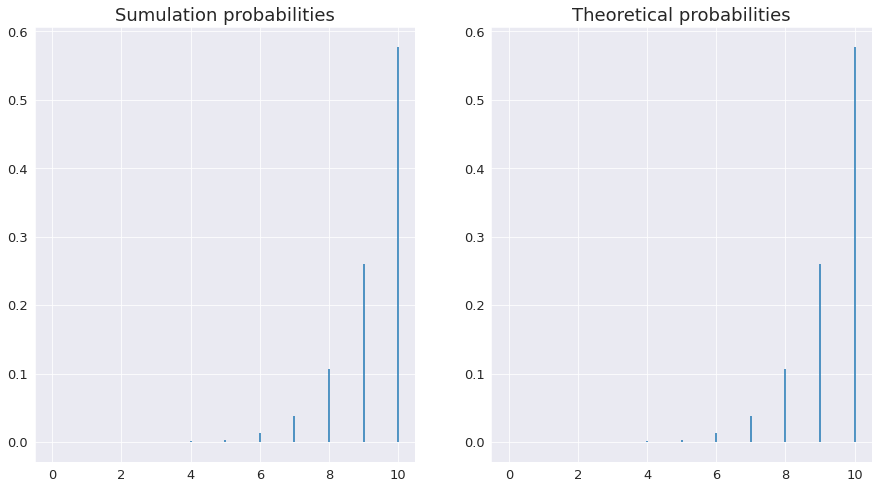

In [140]:
plot_histograms(system_state_probabilities, theoretical_state_probabilities)

### Refuse probability 

In [141]:
theoretical_refuse_probability = compute_refuse_probability(theoretical_state_probabilities)
empirical_refuse_probability = compute_refuse_probability(system_state_probabilities)
theoretical_refuse_probability, empirical_refuse_probability

(0.575669090346648, 0.5777843221023539)

### Relative throughput

In [142]:
theoretical_relative_probability = compute_relative_throughput(theoretical_state_probabilities)
empirical_relative_probability = compute_relative_throughput(system_state_probabilities)
theoretical_relative_probability, empirical_relative_probability

(0.42433090965335196, 0.42221567789764614)

### Absolute throughput

In [143]:
theoretical_absolute_throughput = compute_absolute_throughput(theoretical_state_probabilities, arrival_rate)
empirical_absolute_throughput = compute_absolute_throughput(system_state_probabilities, arrival_rate)
theoretical_absolute_throughput, empirical_absolute_throughput

(0.8486618193067039, 0.8444313557952923)

### Mean busy channels count

In [144]:
theoretical_mean_channels_count = compute_mean_busy_channels_count(theoretical_state_probabilities, channels_count)
empirical_mean_channels_count = compute_mean_busy_channels_count(system_state_probabilities, channels_count)
theoretical_mean_channels_count, empirical_mean_channels_count

(9.335280012373742, 9.336551301423187)